In [1]:
import argparse
import sys
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
from pathlib import Path

thispath = Path().resolve()
base_path = thispath.parent
sys.path.insert(0, str(base_path))
from utils import plots
from utils.metrics import dice_score, rel_abs_vol_dif, avd, haussdorf
from utils.plots import plot_dice, plot_hausorf, plot_ravd, plot_avd

### Define all necessary paths

In [3]:
data_path = base_path / 'data'
test_set_path = data_path / 'test_set'
train_set_path = data_path / 'train_set'
val_set_path = data_path / 'validation_set'
params_path =  base_path / 'elastix' / 'parameter_maps' / 'Par0010'
our_atlas_path = data_path / 'ibsr_atlas'
mni_atlas_path = data_path / 'mni_atlas'

Define a dictibary to correct the experiment names so they are suitable for the report

In [4]:
code_exp_names = {
    'EM--random_init--np_atlas': 'EM--random_init--no_atlas',
    'EM--random_init--no_atlas': 'EM--random_init--no_atlas',
    'EM--kmeans_init--no_atlas': 'EM--kmeans_init--no_atlas',
    'EM--tissue_models_init--no_atlas': 'EM--tissue_models_init--no_atlas',
    'EM--tissue_models_init--atlas_after_multi': 'EM--tissue_models_init--atlas_after_prob-multi',
    'EM--tissue_models_init--atlas_into_multi': 'EM--tissue_models_init--atlas_into_prob-multi', 
    'EM--tissue_models_init--atlas_after_misa': 'EM--tissue_models_init--atlas_after_prob-ibsr18',
    'EM--tissue_models_init--atlas_into_misa': 'EM--tissue_models_init--atlas_into_prob-ibsr18',
    'EM--misa_atlas_init--no_atlas': 'EM--prob-ibsr18_atlas_init--no_atlas',
    'EM--misa_atlas_init--atlas_into_misa': 'EM--prob-ibsr18_atlas_init--atlas_into_prob-ibsr18',
    'EM--misa_atlas_init--atlas_after_misa': 'EM--prob-ibsr18_atlas_init--atlas_after_prob-ibsr18',
    'EM--multi_atlas_init--no_atlas': 'EM--prob-multi_atlas_init--no_atlas',
    'EM--multi_atlas_init--atlas_into_multi': 'EM--prob-multi_atlas_init--atlas_into_prob-multi',
    'EM--multi_atlas_init--atlas_after_multi': 'EM--prob-multi_atlas_init--atlas_after_prob-multi'
}

### Analyze train set results for EM (compute metrics)

In [5]:
# Define the paths, experiments we want and cases we want
experiments_path = base_path / 'experiments/train_results'
savepath = base_path / 'experiments/train_results'
exp_names = [
    'EM--random_init--np_atlas', 'EM--random_init--no_atlas', 'EM--kmeans_init--no_atlas', 'EM--tissue_models_init--no_atlas',
    'EM--tissue_models_init--atlas_after_multi', 'EM--tissue_models_init--atlas_into_multi', 
    'EM--tissue_models_init--atlas_after_misa', 'EM--tissue_models_init--atlas_into_misa',
    'EM--misa_atlas_init--no_atlas', 'EM--misa_atlas_init--atlas_into_misa', 'EM--misa_atlas_init--atlas_after_misa',
    'EM--multi_atlas_init--no_atlas', 'EM--multi_atlas_init--atlas_into_multi', 'EM--multi_atlas_init--atlas_after_multi'
]
cases = ['IBSR_01', 'IBSR_03', 'IBSR_04', 'IBSR_05', 'IBSR_06', 'IBSR_07', 'IBSR_08', 'IBSR_09', 'IBSR_16', 'IBSR_18']
savepath.mkdir(exist_ok=True, parents=True)
data_path = base_path / 'data' / ('validation_set' if 'val' in str(experiments_path) else 'train_set')
segs_path = [experiments_path / exp / 'segmentations' for exp in exp_names]

# Get results from the experiments
dices = []
for experiment_path in experiments_path.iterdir():
    if experiment_path.name not in exp_names:
        continue
    dices.append(pd.read_csv(experiment_path / 'results.csv', index_col=0))
    dice_scores = pd.concat(dices, ignore_index=True)

dice_scores.experiment_name.replace('EM--random_init--np_atlas', 'EM--random_init--no_atlas', inplace=True)

# Compute again the dices and all the remaining metrics
new_results_df = []
for row in tqdm(dice_scores.iterrows(), total=len(dice_scores)):
    # Get segmentation and ground truth
    segm_path = experiments_path / row[1].experiment_name / 'segmentations'/ f'{row[1].id}.nii.gz'
    gt_path = data_path / row[1].id / f'{row[1].id}_seg.nii.gz'
    segm_img = sitk.ReadImage(str(segm_path))
    segm_array = sitk.GetArrayFromImage(segm_img)
    gt_array = sitk.GetArrayFromImage(sitk.ReadImage(str(gt_path)))
    
    # Compute the metrics
    dsc = dice_score(gt_array, segm_array)
    ravd = rel_abs_vol_dif(gt_array, segm_array)
    avd_values = avd(gt_array, segm_array, segm_img.GetSpacing())
    hd = haussdorf(gt_array, segm_array, segm_img.GetSpacing())
    
    # Accumulate the results
    row_list = [
        row[1].experiment_name, row[1].algorithm, row[1].initialization, row[1].id, row[1].n_iters, row[1].time,
        dsc[0], dsc[1], dsc[2], ravd[0], ravd[1], ravd[2], avd_values[0], avd_values[1], avd_values[2], hd[0], hd[1], hd[2]
    ]
    new_results_df.append(row_list)

# Generate a new df
new_results_df = pd.DataFrame(
    new_results_df,
    columns=['experiment_name', 'algorithm', 'initialization', 'id', 'n_iters', 'time',
             'dice_csf', 'dice_gm', 'dice_wm', 'ravd_csf', 'ravd_gm', 'ravd_wm', 'avd_csf', 'avd_gm', 'avd_wm', 'hd_csf', 'hd_gm', 'hd_wm'
             ]
)
# Adjust experiment names
new_results_df.experiment_name.replace(code_exp_names, inplace=True)
# Save
# new_results_df.to_csv(savepath/'complete_metrics_EM.csv')

100%|██████████| 130/130 [22:51<00:00, 10.55s/it]


### Analyze train set results for EM (plot results)

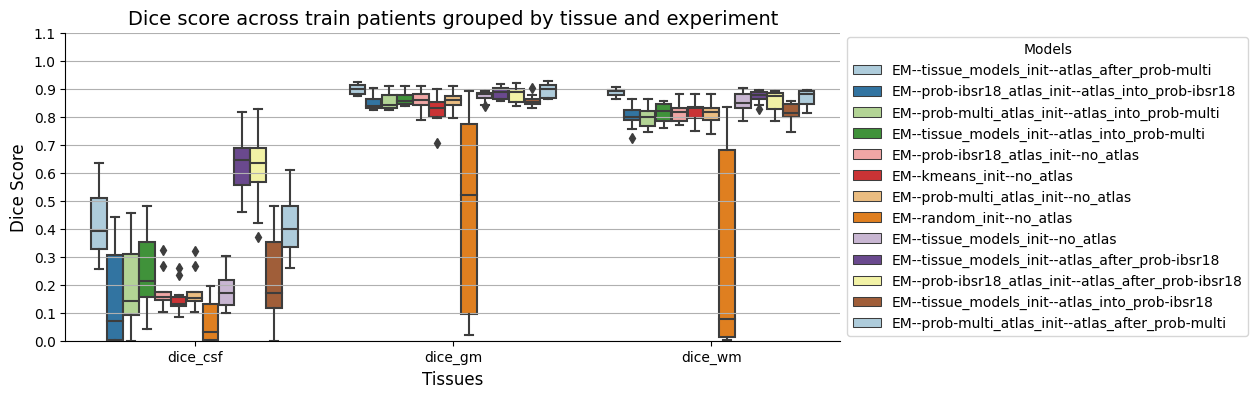

<Figure size 640x480 with 0 Axes>

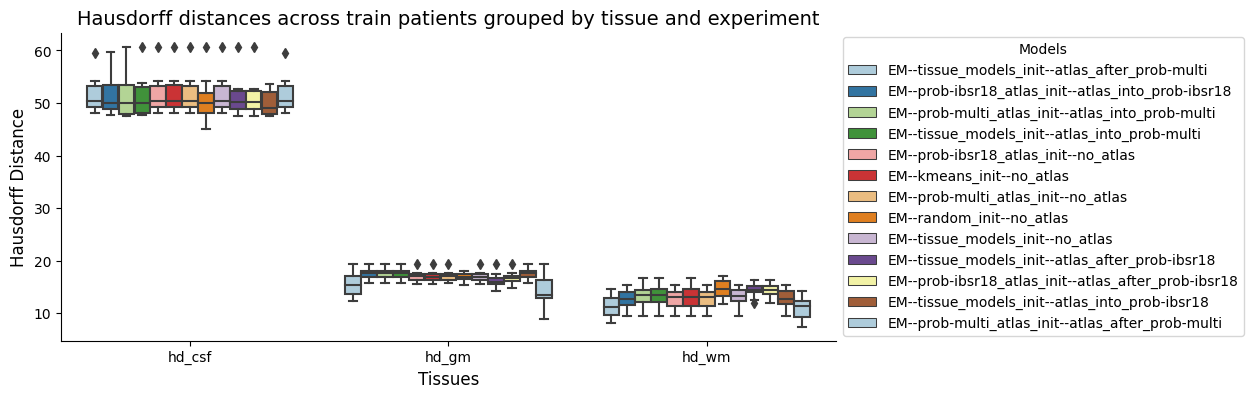

<Figure size 640x480 with 0 Axes>

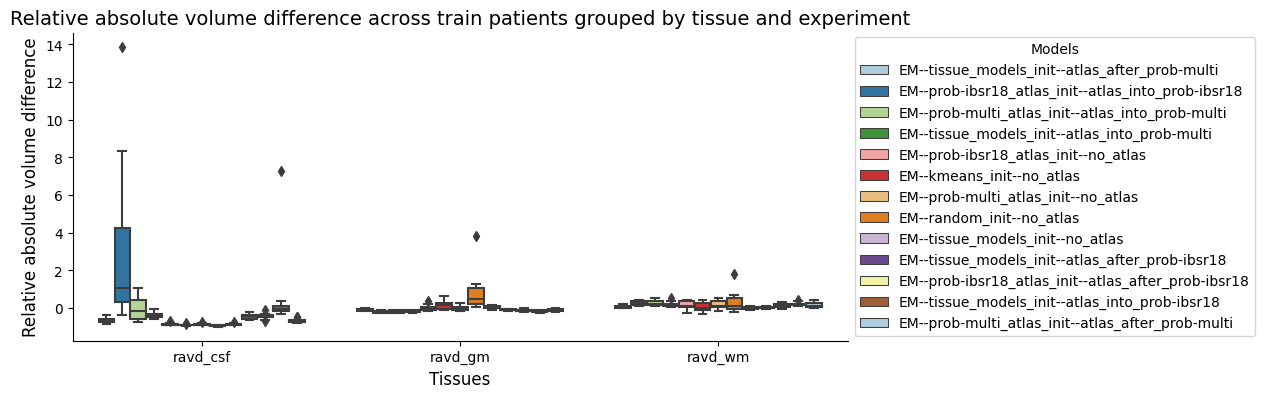

<Figure size 640x480 with 0 Axes>

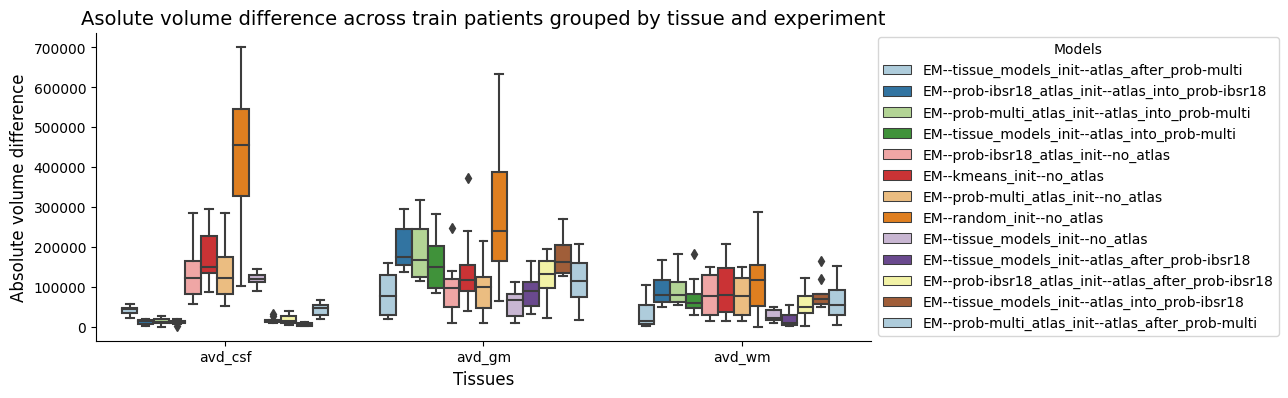

<Figure size 640x480 with 0 Axes>

In [7]:
new_results_df = pd.read_csv(savepath/'complete_metrics_EM.csv')

# Plot dice
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time'],
    value_vars=['dice_csf', 'dice_gm', 'dice_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time', 'tissue', 'dice']
plot_dice(df, 'train')
plt.savefig(savepath/'dices_train_EM.svg', bbox_inches='tight', format='svg')
plt.show()


# Plot hausdorff
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time'],
    value_vars=['hd_csf', 'hd_gm', 'hd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time', 'tissue', 'hausdorff']
plot_hausorf(df, 'train')
plt.savefig(savepath/'hd_train_EM.svg', bbox_inches='tight', format='svg')
plt.show()

# Plot ravd
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time'],
    value_vars=['ravd_csf', 'ravd_gm', 'ravd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time', 'tissue', 'ravd']
plot_ravd(df, 'train')
plt.savefig(savepath/'ravd_train_EM.svg', bbox_inches='tight', format='svg')
plt.show()

# Plot avd
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time'],
    value_vars=['avd_csf', 'avd_gm', 'avd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time', 'tissue', 'avd']
plot_avd(df, 'train')
plt.savefig(savepath/'avd_train_EM.svg', bbox_inches='tight', format='svg')
plt.show()

### Analyze validation set results for EM (compute metrics)

In [8]:
# Define the paths, experiments we want and cases we want
experiments_path = base_path / 'experiments/val_results'
savepath = base_path / 'experiments/val_results'
exp_names = [
    'EM--random_init--no_atlas', 'EM--kmeans_init--no_atlas', 'EM--tissue_models_init--no_atlas',
    'EM--tissue_models_init--atlas_after_multi', 'EM--tissue_models_init--atlas_into_multi', 
    'EM--tissue_models_init--atlas_after_misa', 'EM--tissue_models_init--atlas_into_misa',
    'EM--misa_atlas_init--no_atlas', 'EM--misa_atlas_init--atlas_into_misa', 'EM--misa_atlas_init--atlas_after_misa',
    'EM--multi_atlas_init--no_atlas', 'EM--multi_atlas_init--atlas_into_multi', 'EM--multi_atlas_init--atlas_after_multi'
]
cases = ['IBSR_14', 'IBSR_17', 'IBSR_13', 'IBSR_11', 'IBSR_12']
savepath.mkdir(exist_ok=True, parents=True)
data_path = base_path / 'data' / ('validation_set' if 'val' in str(experiments_path) else 'train_set')
segs_path = [experiments_path / exp / 'segmentations' for exp in exp_names]

# Get results from the experiments
dices = []
for experiment_path in experiments_path.iterdir():
    if experiment_path.name not in exp_names:
        continue
    dices.append(pd.read_csv(experiment_path / 'results.csv', index_col=0))
    dice_scores = pd.concat(dices, ignore_index=True)

# Compute again the dices and all the remaining metrics
new_results_df = []
for row in tqdm(dice_scores.iterrows(), total=len(dice_scores)):
    # Get segmentation and ground truth
    segm_path = experiments_path / row[1].experiment_name / 'segmentations'/ f'{row[1].id}.nii.gz'
    gt_path = data_path / row[1].id / f'{row[1].id}_seg.nii.gz'
    segm_img = sitk.ReadImage(str(segm_path))
    segm_array = sitk.GetArrayFromImage(segm_img)
    gt_array = sitk.GetArrayFromImage(sitk.ReadImage(str(gt_path)))
    
    # Compute the metrics
    dsc = dice_score(gt_array, segm_array)
    ravd = rel_abs_vol_dif(gt_array, segm_array)
    avd_values = avd(gt_array, segm_array, segm_img.GetSpacing())
    hd = haussdorf(gt_array, segm_array, segm_img.GetSpacing())
    
    # Accumulate the results
    row_list = [
        row[1].experiment_name, row[1].algorithm, row[1].initialization, row[1].id, row[1].n_iters, row[1].time,
        dsc[0], dsc[1], dsc[2], ravd[0], ravd[1], ravd[2], avd_values[0], avd_values[1], avd_values[2], hd[0], hd[1], hd[2]
    ]
    new_results_df.append(row_list)

# Generate a new df
new_results_df = pd.DataFrame(
    new_results_df,
    columns=['experiment_name', 'algorithm', 'initialization', 'id', 'n_iters', 'time',
             'dice_csf', 'dice_gm', 'dice_wm', 'ravd_csf', 'ravd_gm', 'ravd_wm', 'avd_csf', 'avd_gm', 'avd_wm', 'hd_csf', 'hd_gm', 'hd_wm'
             ]
)

#Adjust experiment names
new_results_df.experiment_name.replace(code_exp_names, inplace=True)
# Save
# new_results_df.to_csv(savepath/'complete_metrics_EM.csv')

### Analyze validation set results for EM (plot results)

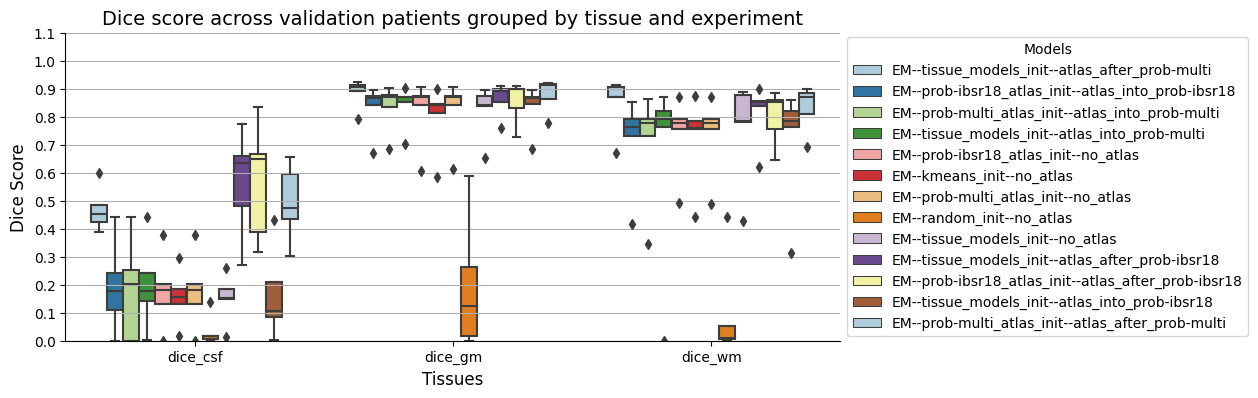

<Figure size 640x480 with 0 Axes>

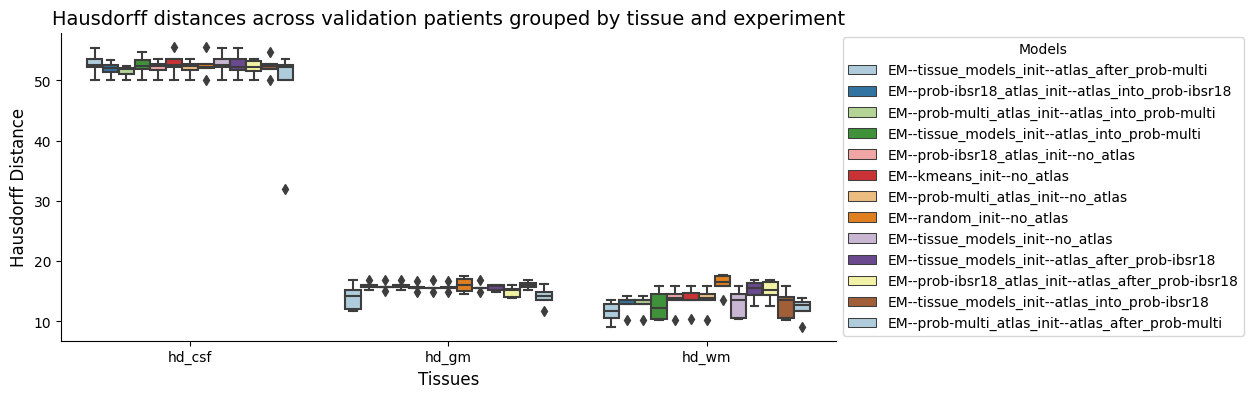

<Figure size 640x480 with 0 Axes>

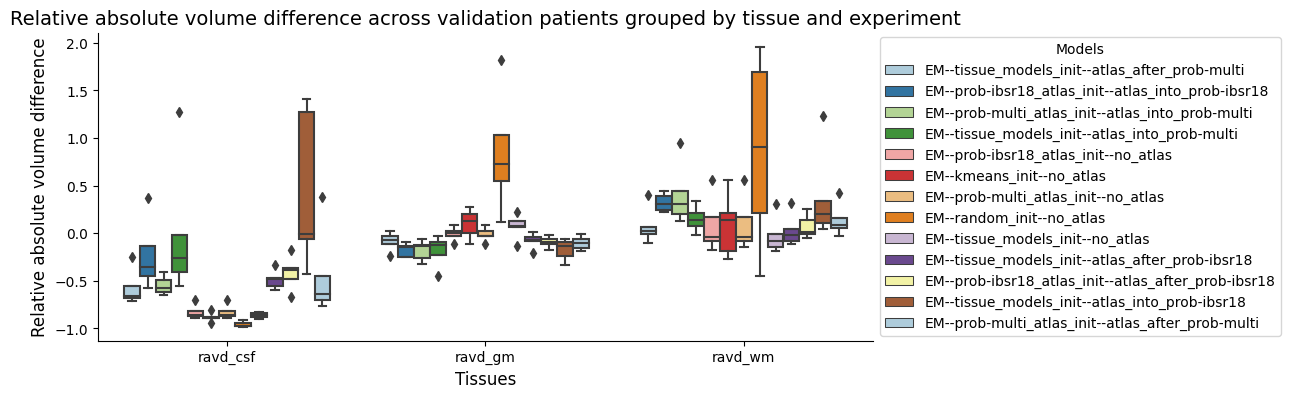

<Figure size 640x480 with 0 Axes>

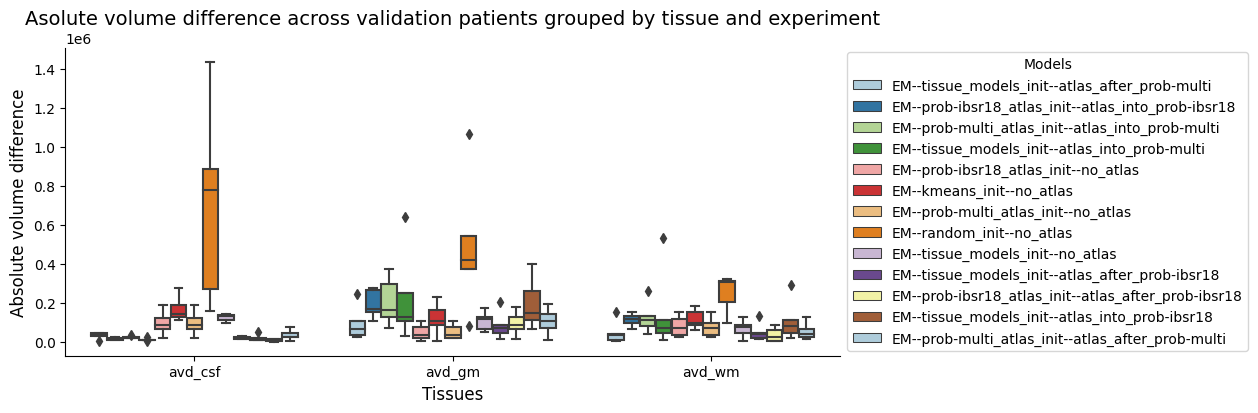

<Figure size 640x480 with 0 Axes>

In [9]:
# new_results_df = pd.read_csv(savepath/'complete_metrics_EM.csv', index_col=0)

# Plot dice
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time'],
    value_vars=['dice_csf', 'dice_gm', 'dice_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time', 'tissue', 'dice']
plot_dice(df, 'validation')
plt.savefig(savepath/'dices_val_EM.svg', bbox_inches='tight', format='svg')
plt.show()


# Plot hausdorff
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time'],
    value_vars=['hd_csf', 'hd_gm', 'hd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time', 'tissue', 'hausdorff']
plot_hausorf(df, 'validation')
plt.savefig(savepath/'hd_val_EM.svg', bbox_inches='tight', format='svg')
plt.show()

# Plot ravd
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time'],
    value_vars=['ravd_csf', 'ravd_gm', 'ravd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time', 'tissue', 'ravd']
plot_ravd(df, 'validation')
plt.savefig(savepath/'ravd_val_EM.svg', bbox_inches='tight', format='svg')
plt.show()

# Plot avd
df = pd.melt(
    new_results_df,
    id_vars=['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time'],
    value_vars=['avd_csf', 'avd_gm', 'avd_wm'], ignore_index=False
)
df.columns = ['experiment_name', 'algorithm', 'initialization', 'n_iters', 'time', 'tissue', 'avd']
plot_avd(df, 'validation')
plt.savefig(savepath/'avd_val_EM.svg', bbox_inches='tight', format='svg')
plt.show()